In [1]:
%load_ext lab_black
%matplotlib inline

import pandas as pd
from datetime import datetime, timezone
from pathlib import Path
from tqdm.auto import tqdm
from traffic.core import Traffic, Flight
from traffic.data import airports, opensky
import matplotlib.pyplot as plt
from ipyleaflet import Map, basemaps, CircleMarker, LegendControl, projections
from ipywidgets import Layout
import seaborn as sns

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## Download 8 Airfrance flights in zones with good ADS-B covering

In [2]:
output_dir = Path("../results/")
year, month = 2021, 12
for flight in [
    ("AFR21ZQ", ("LFPO", "LFBO"), [2, 3, 5]),
    ("AFR962", ("LFPG", "LLBG"), [5, 8, 9]),
    ("AFR1044", ("LFPG", "UUEE"), [8]),
    ("AFR16BR", ("LFPG", "EDDF"), [8]),
]:
    callsign, city_pair, days = flight[0], flight[1], flight[2]
    for day in days:
        date = datetime(year, month, day, 0, 0, 0, tzinfo=timezone.utc)
        filename = f"{callsign}_{date:%Y-%m-%d}_history.pkl.gz"
        print(filename)

        if (output_dir / filename).exists():
            continue

        history = opensky.history(
            date,
            departure_airport=city_pair[0],
            arrival_airport=city_pair[1],
            callsign=callsign,
        )
        if history is None:
            print("No flights", date, callsign)
            continue
        output = history.iterate_lazy().resample("10s").eval(desc="", max_workers=8)
        output.to_pickle(output_dir / filename)

Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/opensky_impala.py:910: TqdmExperimentalWarning: rich is experimental/alpha
  for bt, at, bh, ah in progressbar(sequence):


AFR21ZQ_2021-12-02_history.pkl.gz


Output()

/home/luis/repos/traffic/traffic/core/lazy.py:228: TqdmExperimentalWarning: rich is experimental/alpha
  tasks_completed = tqdm(


Output()

AFR21ZQ_2021-12-03_history.pkl.gz


Output()

Output()

AFR21ZQ_2021-12-05_history.pkl.gz


Output()

Output()

AFR962_2021-12-05_history.pkl.gz


Output()

Output()

AFR962_2021-12-08_history.pkl.gz


Output()

Output()

AFR962_2021-12-09_history.pkl.gz


Output()

Output()

AFR1044_2021-12-08_history.pkl.gz


Output()

Output()

AFR16BR_2021-12-08_history.pkl.gz


Output()

In [4]:
file_list = list(output_dir.glob("../results/*.pkl.gz"))
cumul = []
for f in file_list:
    cumul.append(pd.read_pickle(f))
t = Traffic(pd.concat(cumul))
t

,,count
icao24,callsign,
3949e2,AFR962,1433
39cf06,AFR962,1187
39c420,AFR962,1171
396443,AFR1044,1065
3985a0,AFR21ZQ,332
39856c,AFR16BR,323
393322,AFR21ZQ,315
3944ef,AFR21ZQ,312


In [5]:
t_prep = (
    t.iterate_lazy(iterate_kw=dict(by="40T"))
    .assign_id()
    .eval(desc="preprocessing", max_workers=8)
)
t_prep

Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/core/lazy.py:228: TqdmExperimentalWarning: rich is experimental/alpha
  tasks_completed = tqdm(


,count
flight_id,
AFR962_002,1433
AFR962_007,1187
AFR962_006,1171
AFR1044_003,1065
AFR21ZQ_005,332
AFR16BR_004,323
AFR21ZQ_000,315
AFR21ZQ_001,312


In [6]:
t_prep.groupby("flight_id")[["origin", "destination"]].first().reset_index().groupby(
    ["origin", "destination"]
).count().rename(columns={"flight_id": "num_flights"})

num_flights
origin destination             
LFPG   EDDF                   1
       LLBG                   3
       UUEE                   1
LFPO   LFBO                   3

In [7]:
t_map = t_prep

map_ = Map(
    center=(43, 5),
    zoom=4,
    layout=Layout(width="60%", max_width="1000px", height="500px"),
)

pal = sns.color_palette("husl", n_colors=len(t_map)).as_hex()

colors = dict(
    (f"{f.flight_id} - {f.callsign} / {f.icao24} / {f.origin} -> {f.destination}", c)
    for f, c in zip(t_map, pal)
)

legend = LegendControl(
    colors,
    name="Legend",
    position="topleft",
)
map_.add_control(legend)


it_pal = iter(pal)
for i, flight in enumerate(t_map):
    color = next(it_pal)
    for i, c in enumerate(flight.coords):
        if i % 20 == 0:
            marker = CircleMarker(
                location=(c[1], c[0]), color=color, radius=2, weight=2
            )
            map_.add_layer(marker)

map_

Map(center=[43, 5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [8]:
cumul = []
for flight in t_prep:
    ehs_flight = flight.query_ehs().unwrap()
    cumul.append(ehs_flight)

t_ehs = Traffic.from_flights(cumul)
t_ehs.to_pickle("../results/t_ehs_raw.pkl")

Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/opensky_impala.py:1289: TqdmExperimentalWarning: rich is experimental/alpha
  for bt, at, bh, ah in progressbar(sequence):


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


Output()

/home/luis/repos/traffic/traffic/data/adsb/opensky_impala.py:1289: TqdmExperimentalWarning: rich is experimental/alpha
  for bt, at, bh, ah in progressbar(sequence):


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


Output()

/home/luis/repos/traffic/traffic/data/adsb/opensky_impala.py:1289: TqdmExperimentalWarning: rich is experimental/alpha
  for bt, at, bh, ah in progressbar(sequence):


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


Output()

/home/luis/repos/traffic/traffic/data/adsb/opensky_impala.py:1289: TqdmExperimentalWarning: rich is experimental/alpha
  for bt, at, bh, ah in progressbar(sequence):


Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/data/adsb/raw_data.py:74: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm(  # type: ignore


## Preprocessing

In [9]:
t = (
    Traffic.from_file("t_ehs_raw.pkl")
    .clean_invalid()
    .resample("1s")
    .filter(altitude=23, track=53, heading=53, groundspeed=53, TAS=53, vertical_rate=53)
    .phases()
    .eval(desc="preprocessing", max_workers=8)
)
t.to_pickle("../results/t_ehs.pkl")

Output()

/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/ipy
widgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated
in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/luis/repos/traffic/traffic/core/lazy.py:228: TqdmExperimentalWarning: rich is experimental/alpha
  tasks_completed = tqdm(
/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/skfuzzy/image/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) > LooseVersion("1.8"):
/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/skfuzzy/__init__.py:65: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/site-packages/skfuzzy/image/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) > LooseVersion("1.8"):
/home/luis/.cache/pypoetry/virtualenvs/traffic-0U6Qm8Lw-py3.9/lib/python3.9/sit

In [10]:
def plot(t, tf, col):
    with plt.style.context("traffic"):
        fig, ax_ = plt.subplots(len(t), 2, figsize=(30, 50))
        for f, ff, ax in zip(t, tf, ax_):
            f.plot_time(ax[0], col)
            ff.plot_time(ax[1], col)


t_raw = Traffic.from_file("../results/t_ehs_raw.pkl")
t = Traffic.from_file("../results/t_ehs.pkl")

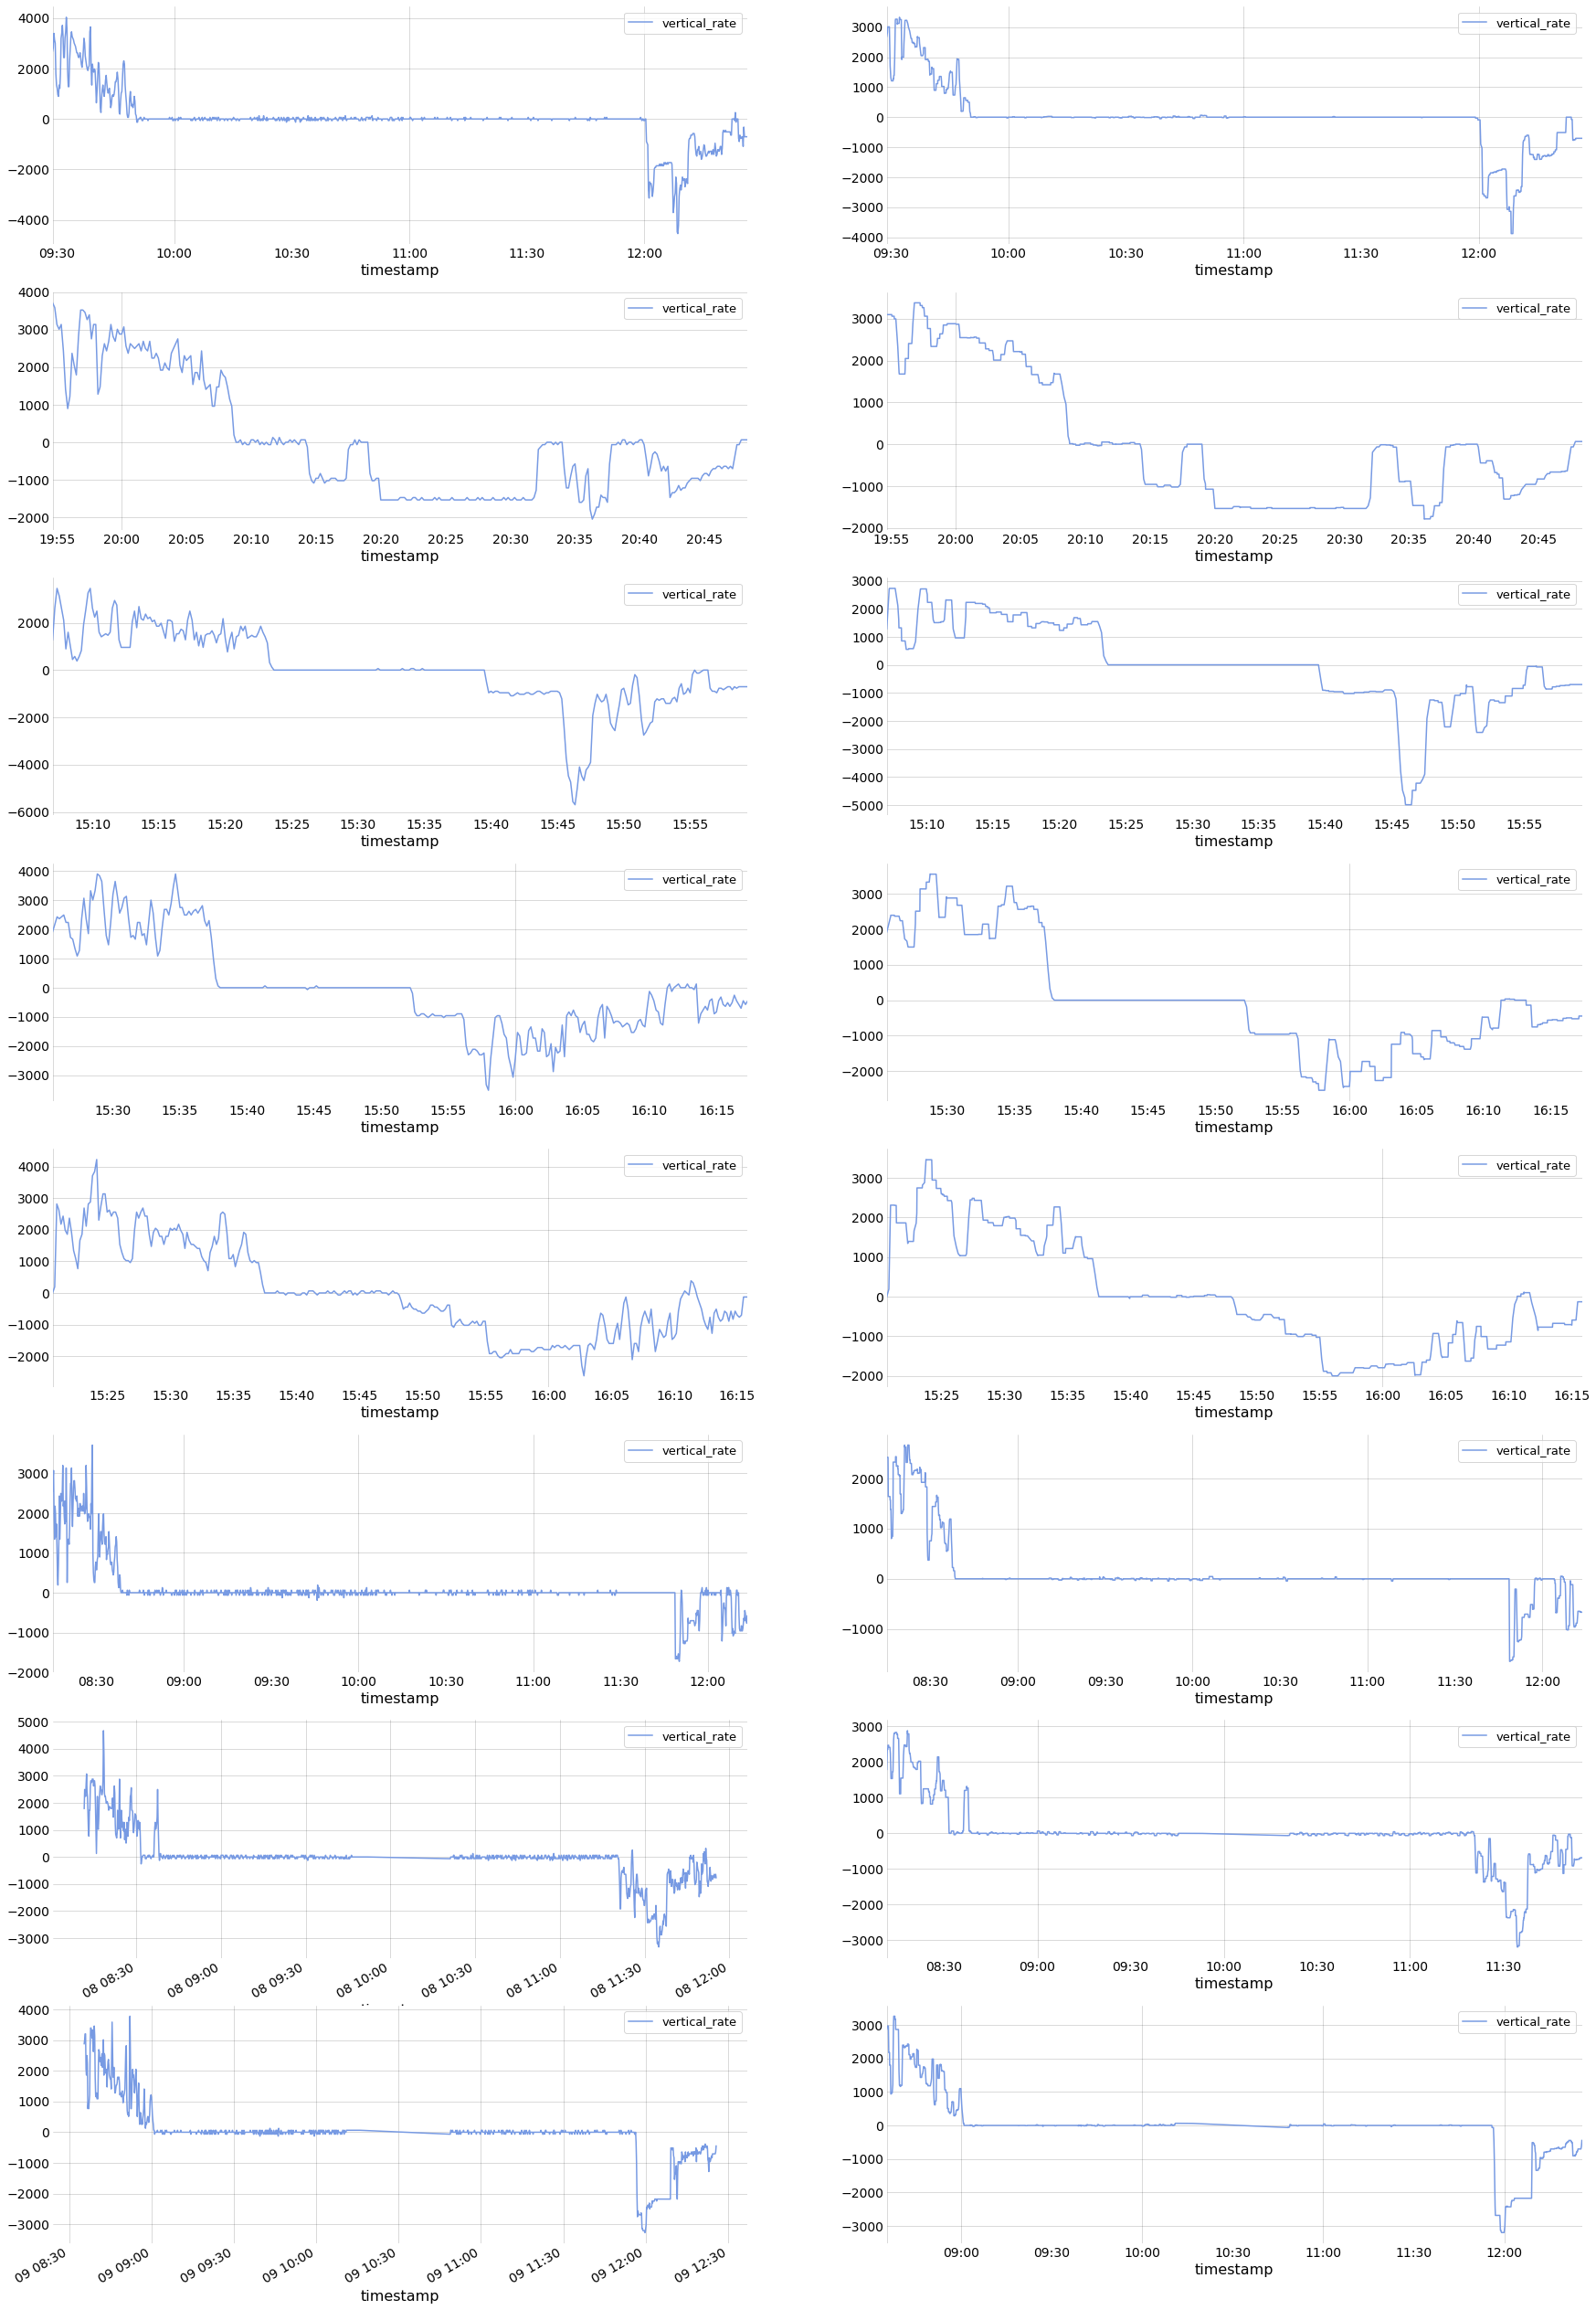

In [11]:
plot(t_raw, t, "vertical_rate")

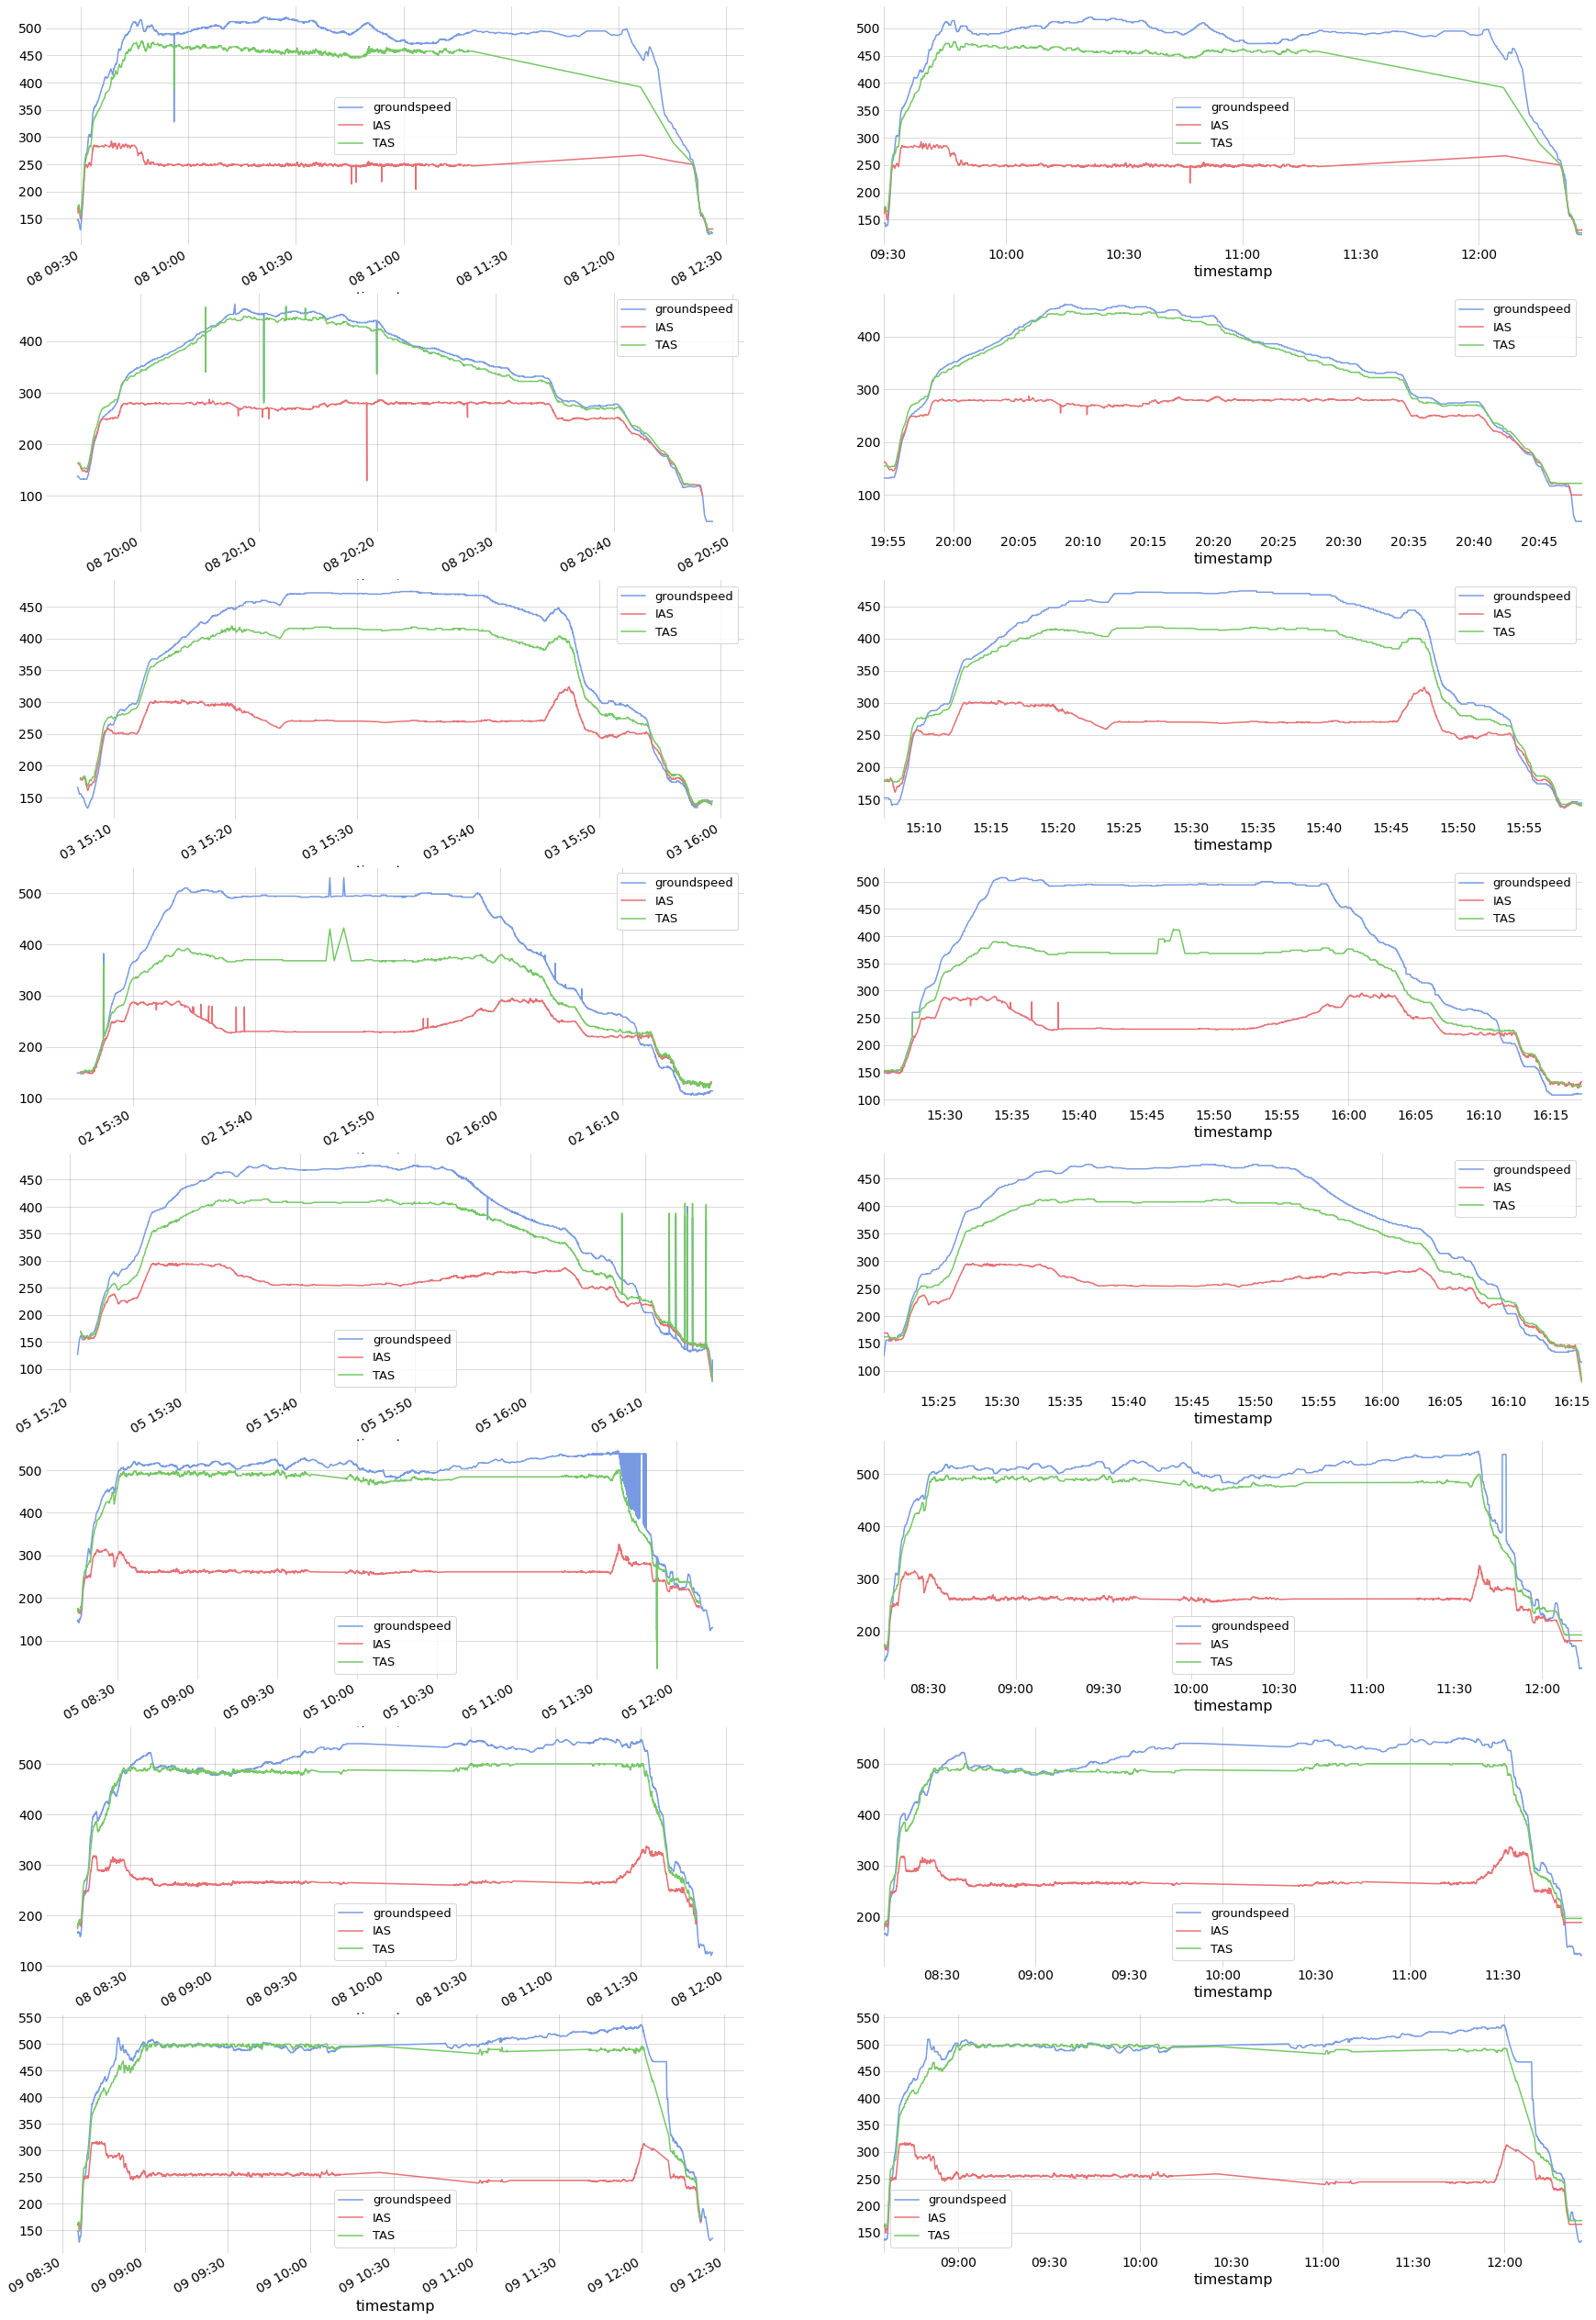

In [12]:
plot(t_raw, t, ["groundspeed", "IAS", "TAS"])

## Export

In [13]:
cols = [
    "timestamp",
    "icao24",
    "callsign",
    "flight_id",
    "onground",
    "IAS",
    "TAS",
    "groundspeed",
    "altitude",
    "destination",
    "geoaltitude",
    "latitude",
    "longitude",
    "vertical_rate",
]

t = t.drop(columns=[col for col in t.data.columns if col not in cols])
t

,count
flight_id,
AFR962_002,14321
AFR962_007,13811
AFR962_006,13431
AFR1044_003,10641
AFR21ZQ_005,3311
AFR16BR_004,3221
AFR21ZQ_000,3141
AFR21ZQ_001,3111


In [14]:
t.data.isna().sum()

timestamp        0
icao24           0
IAS              0
altitude         0
groundspeed      0
TAS              0
callsign         0
destination      0
geoaltitude      0
latitude         0
longitude        0
onground         0
vertical_rate    0
flight_id        0
dtype: int64

In [17]:
t.to_parquet("../results/adsb_sample.parquet", index=False)
t.to_csv("../results/adsb_sample.csv", index=False)

In [16]:
t.from_file("../results/adsb_sample.parquet")

,count
flight_id,
AFR962_002,14321
AFR962_007,13811
AFR962_006,13431
AFR1044_003,10641
AFR21ZQ_005,3311
AFR16BR_004,3221
AFR21ZQ_000,3141
AFR21ZQ_001,3111
